In [1]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login
! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Usi

In [2]:

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from sklearn.metrics import accuracy_score

In [10]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


##Testing Wiki Chatgpt dataset

In [5]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_chatgpt_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['model', 'source_id', 'source', 'prompt', 'machine_text', 'human_text']


In [4]:
from datasets import Dataset

def prepare_dataset(data, abstract = "human_text", machine_abstract = "machine_text"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})
    return dataset


In [8]:
wiki_gpt_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_gpt_test_data))


Size of the dataset: 1198


In [5]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        #print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}



In [10]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_gpt_test_data = wiki_gpt_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

In [11]:
df_test_dataset_wiki_gpt = wiki_gpt_test_data.to_pandas()
df_test_dataset_wiki_gpt['target_labels'] = df_test_dataset_wiki_gpt['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [12]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_gpt['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_gpt = df_test_dataset_wiki_gpt.dropna(subset=['predicted_labels'])


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[ 2.33722871 97.66277129]
 [ 3.83973289 96.16026711]]


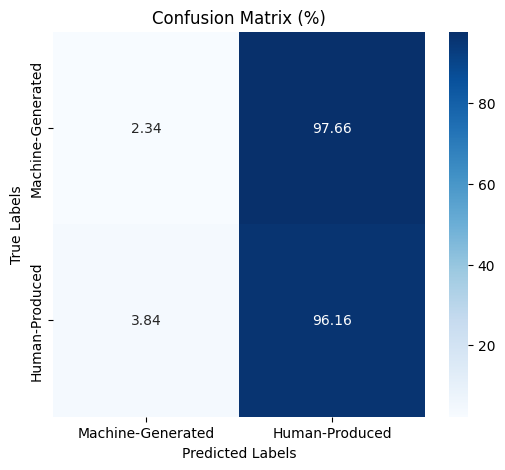

In [14]:
predicted_labels = df_test_dataset_wiki_gpt.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_gpt.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Testing with wiki coher dataset

In [15]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_cohere_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['model', 'source_id', 'source', 'prompt', 'machine_text', 'human_text']


In [16]:
wiki_coher_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_coher_test_data))


Size of the dataset: 936


In [17]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_coher_test_data = wiki_coher_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/936 [00:00<?, ? examples/s]

In [18]:
df_test_dataset_wiki_coher = wiki_coher_test_data.to_pandas()
df_test_dataset_wiki_coher['target_labels'] = df_test_dataset_wiki_coher['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [19]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_coher['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_coher = df_test_dataset_wiki_coher.dropna(subset=['predicted_labels'])


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[ 3.84615385 96.15384615]
 [ 4.05982906 95.94017094]]


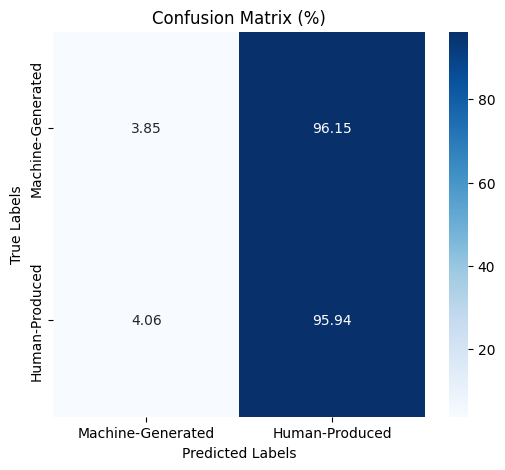

In [20]:
predicted_labels = df_test_dataset_wiki_coher.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_coher.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Testing wiki davinci dataset

In [21]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_davinci_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['model', 'source_id', 'source', 'prompt', 'machine_text', 'human_text']


In [22]:
wiki_davinci_test_data = prepare_dataset(test_data, abstract = 'human_text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_davinci_test_data))


Size of the dataset: 1200


In [24]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [25]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_davinci_test_data = wiki_davinci_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [26]:
df_test_dataset_wiki_davinci = wiki_davinci_test_data.to_pandas()
df_test_dataset_wiki_davinci['target_labels'] = df_test_dataset_wiki_davinci['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [27]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_davinci['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_davinci = df_test_dataset_wiki_davinci.dropna(subset=['predicted_labels'])


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[13.5        86.5       ]
 [ 4.16666667 95.83333333]]


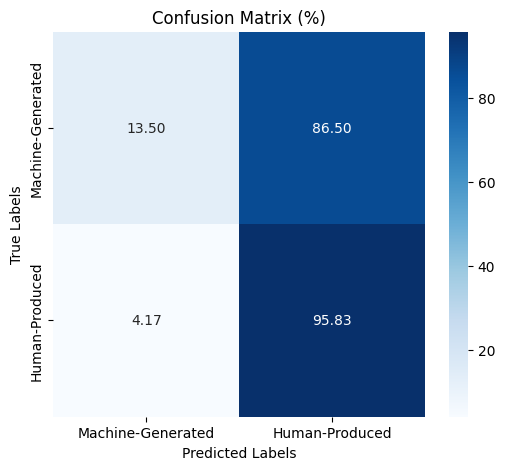

In [28]:
predicted_labels = df_test_dataset_wiki_davinci.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_davinci.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Testing wiki bloomz data

In [6]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/wiki_dataset/wikipedia_bloomz_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['model', 'source', 'logits', 'url', 'machine_text', 'prompt', 'id', 'machine_abstract', 'text', 'score', 'title', 'probas']


In [7]:
wiki_bloomz_test_data = prepare_dataset(test_data, abstract = 'text', machine_abstract = 'machine_text')
print("Size of the dataset:", len(wiki_bloomz_test_data))


Size of the dataset: 1200


In [11]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
wiki_bloomz_test_data = wiki_bloomz_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [12]:
df_test_dataset_wiki_bloomz = wiki_bloomz_test_data.to_pandas()
df_test_dataset_wiki_bloomz['target_labels'] = df_test_dataset_wiki_bloomz['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [13]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_wiki_bloomz['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_wiki_bloomz = df_test_dataset_wiki_bloomz.dropna(subset=['predicted_labels'])


In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'machine-generated', 'human-produced'}
Unique values in true_labels: {'machine-generated', 'human-produced'}
Confusion Matrix in Percentage:
[[ 1.83333333 98.16666667]
 [ 2.83333333 97.16666667]]


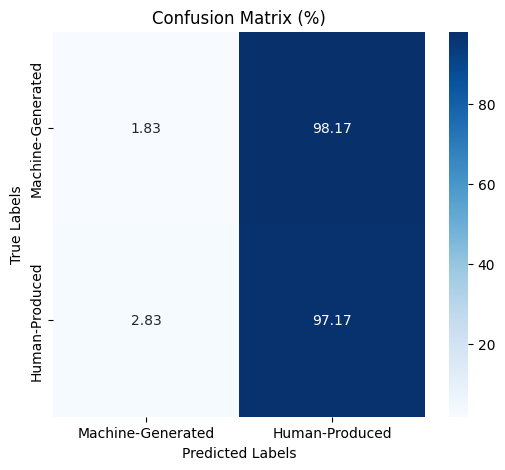

In [16]:
predicted_labels = df_test_dataset_wiki_bloomz.predicted_labels.to_list()
true_labels = df_test_dataset_wiki_bloomz.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()
